In [1]:
import sys

import networkx as nx
import numpy as np

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("../../src/")

from tqdm.auto import tqdm

import synthetic
import utils

# Experiment

**Goal**

Calculate relative size of largest component of remnant layers as a function of PFI.

**Procedure**
1. Generate LFR network or load real multiplex.
2. Observe a subtensor, $\mathcal{O}_f$, for some proportion of information $f$.
3. Calculate remnant $\mathcal{R} = G \setminus \mathcal{O}_f$.
4. Calculate relative size of largest component, $\rho = \frac{|LC(\mathcal{R})|}{|\mathcal{R}|}$
5. Plot $\rho$ as a function of $f$.

## Synthetic

In [2]:
N = 5000
t1 = 2
t2 = 1
mu = 0.3
avg_k = 20
max_k = np.sqrt(N)
min_community = 1
prob_relabel = 1

In [3]:
G, sigma1, sigma2, mu = synthetic.lfr_multiplex (N, t1, t2, mu, avg_k, max_k, min_community, prob_relabel)

In [4]:
G, H = utils.duplex_network(G, 1, 2)

In [5]:
rG, rH, Etest = utils.partial_information(G, H, 0.1)

In [6]:
len(max(nx.connected_components(G), key=len)) / G.number_of_nodes()

0.802

In [7]:
for f in np.linspace(0.1, 0.9, num=10):
    rG, rH, Etest = utils.partial_information(G, H, f)
    lc_rG = len(max(nx.connected_components(rG), key=len)) / rG.number_of_nodes()
    lc_rH = len(max(nx.connected_components(rH), key=len)) / rH.number_of_nodes()
    print(lc_rG, lc_rH)

1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 0.994
0.988 1.0
0.994 0.972
0.98 0.954


## Real Networks

In [8]:
_path = lambda x: f"../../data/input/preprocessed/real/duplex_system={x}.edgelist"

In [9]:
def plot_lc(system, layers):
    D = utils.read_file(_path(system))

    for x, y in layers:
        G, H = utils.duplex_network(D, x, y)
        lc_rG = []
        lc_rH = []
        for f in np.linspace(0.1, 0.9, num=10):
            rG, rH, Etest = utils.partial_information(G, H, f)
            lc_rG.append(len(max(nx.connected_components(rG), key=len)) / rG.number_of_nodes())
            lc_rH.append(len(max(nx.connected_components(rH), key=len)) / rH.number_of_nodes())

        plt.figure()
        plt.plot(lc_rG, marker = ".", label = f"Layer {x}")
        plt.plot(lc_rH, marker = ".", label = f"Layer {y}")
        plt.legend()
        plt.title(system)

### arXiv Collaboration

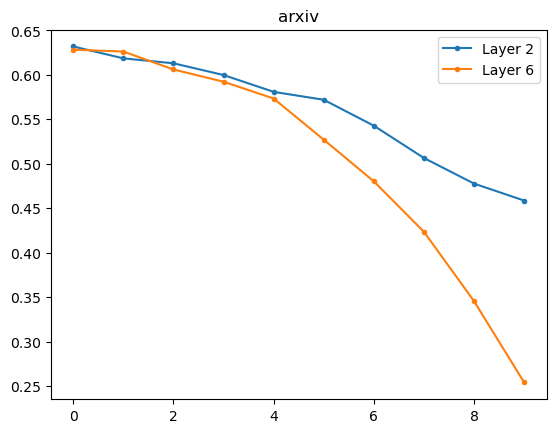

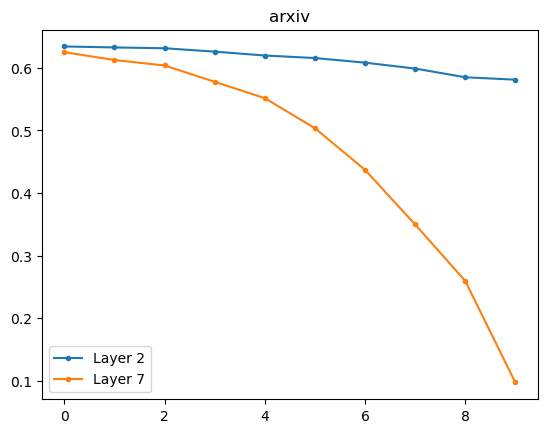

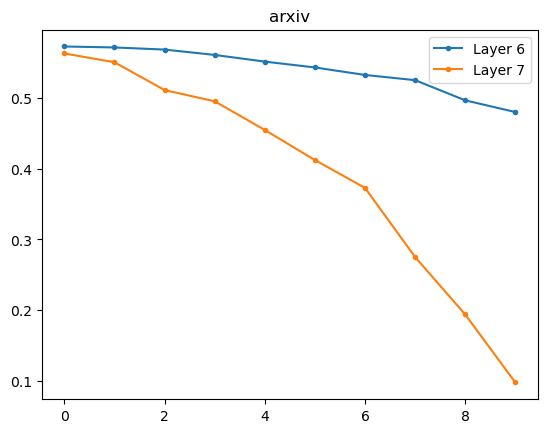

In [10]:
system = "arxiv"
layers = [(2,6), (2,7), (6,7)]
plot_lc(system, layers)

### C. Elegans Connectome

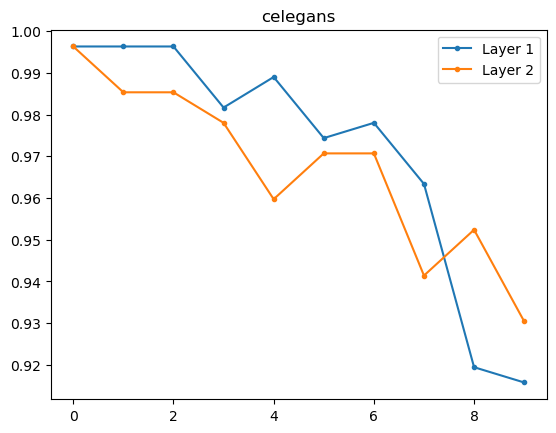

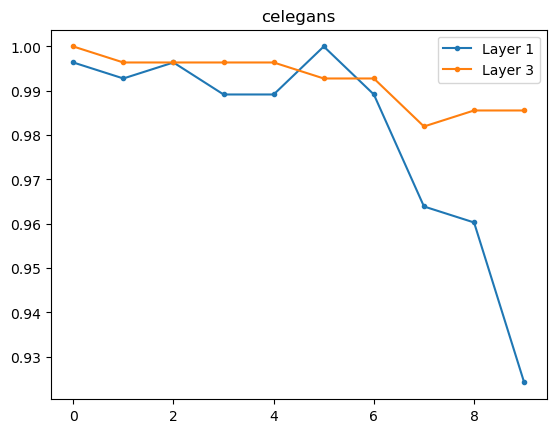

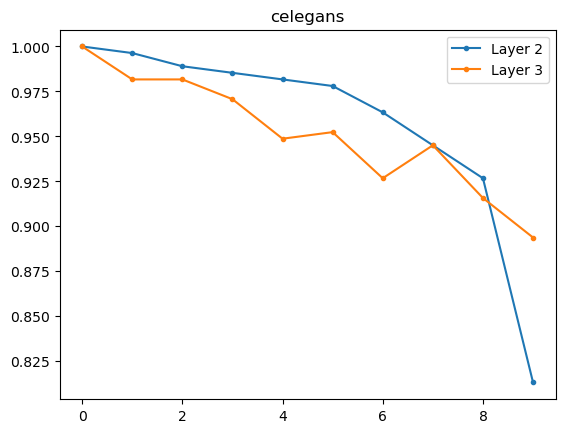

In [11]:
system = "celegans"
layers = [(1,2), (1,3), (2,3)]
plot_lc(system, layers)

### London Transportation

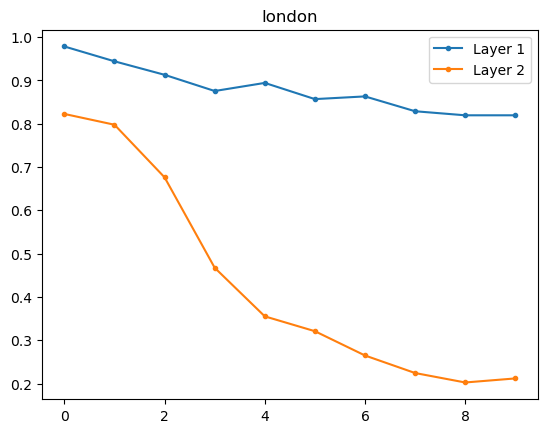

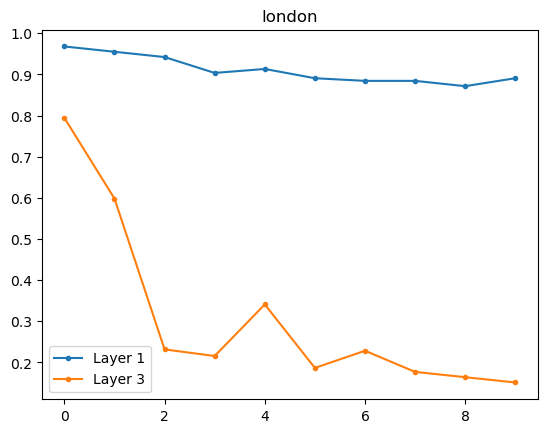

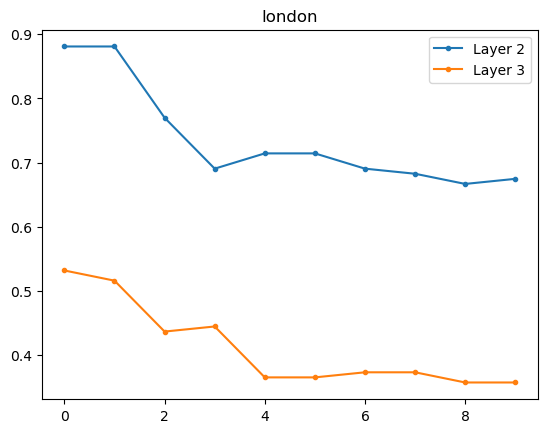

In [12]:
system = "london"
layers = [(1,2), (1,3), (2,3)]
plot_lc(system, layers)

### Drosophila Genomic Interactions

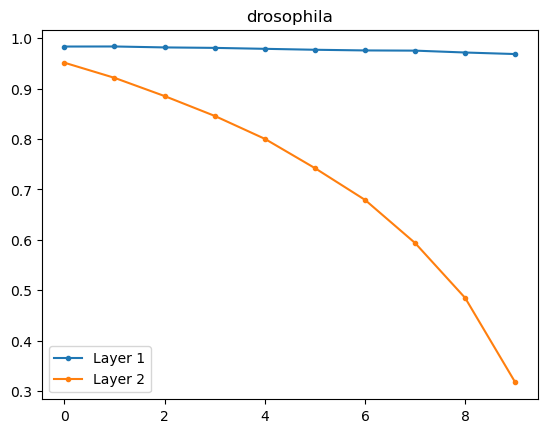

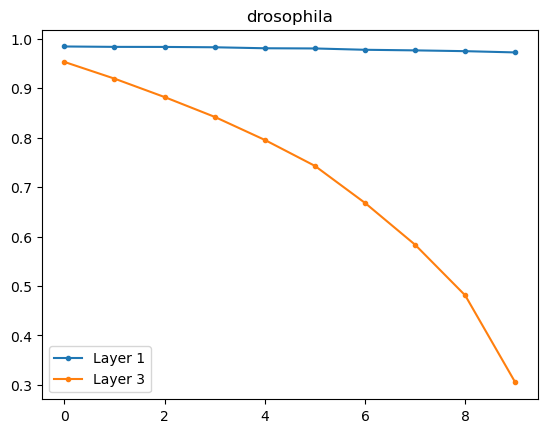

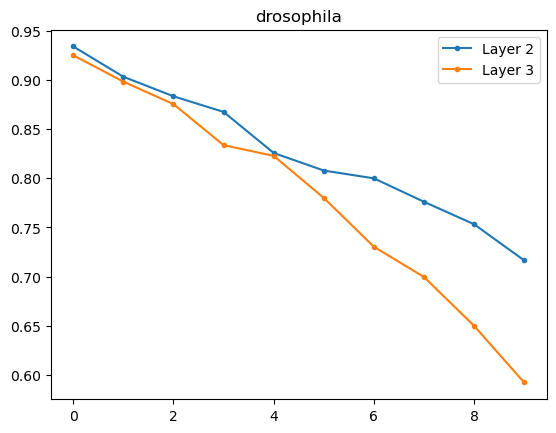

In [13]:
system = "drosophila"
layers = [(1,2), (1,3), (2,3)]
plot_lc(system, layers)

## Amalgamating real system records

In [14]:
def compute_lc(system, layers):
    D = utils.read_file(_path(system))

    records = []
    lc_rGs = []
    lc_rHs = []
    pfis = []
    layers_ = []

    for x, y in layers:
        G, H = utils.duplex_network(D, x, y)
        for f in np.linspace(0.1, 0.9, num=10):
            rG, rH, Etest = utils.partial_information(G, H, f)
            lc_rG = len(max(nx.connected_components(rG), key=len)) / rG.number_of_nodes()
            lc_rH = len(max(nx.connected_components(rH), key=len)) / rH.number_of_nodes()

            lc_rGs.append(lc_rG)
            lc_rHs.append(lc_rH)
            pfis.append(f)
            layers_.append((x,y))

    for idx in range(len(pfis)):
        record = {
            "System": system,
            "Layers": layers_[idx],
            "PFI": pfis[idx],
            "LC_G": lc_rGs[idx],
            "LC_H": lc_rHs[idx],
        }
        records.append(record)

    return records

In [15]:
records = []

for _ in tqdm(range(10)):
    arxiv_ = compute_lc("arxiv", [(2,6), (2,7), (6,7)])
    celegans_ = compute_lc("celegans", [(1,2), (1,3), (2,3)])
    london_ = compute_lc("london", [(1,2), (1,3), (2,3)])
    drosophila_ = compute_lc("drosophila", [(1,2), (1,3), (2,3)])

    records.extend(arxiv_)
    records.extend(celegans_)
    records.extend(london_)
    records.extend(drosophila_)

df_ = pd.DataFrame.from_records(records)

100%|██████████| 10/10 [00:51<00:00,  5.15s/it]


In [16]:
df = pd.melt(df_, id_vars = ["System", "PFI", "Layers"], value_vars=["LC_G", "LC_H"], var_name="Remnant", value_name="LC_Prop")

### Basic Visualizations

<Figure size 640x480 with 0 Axes>

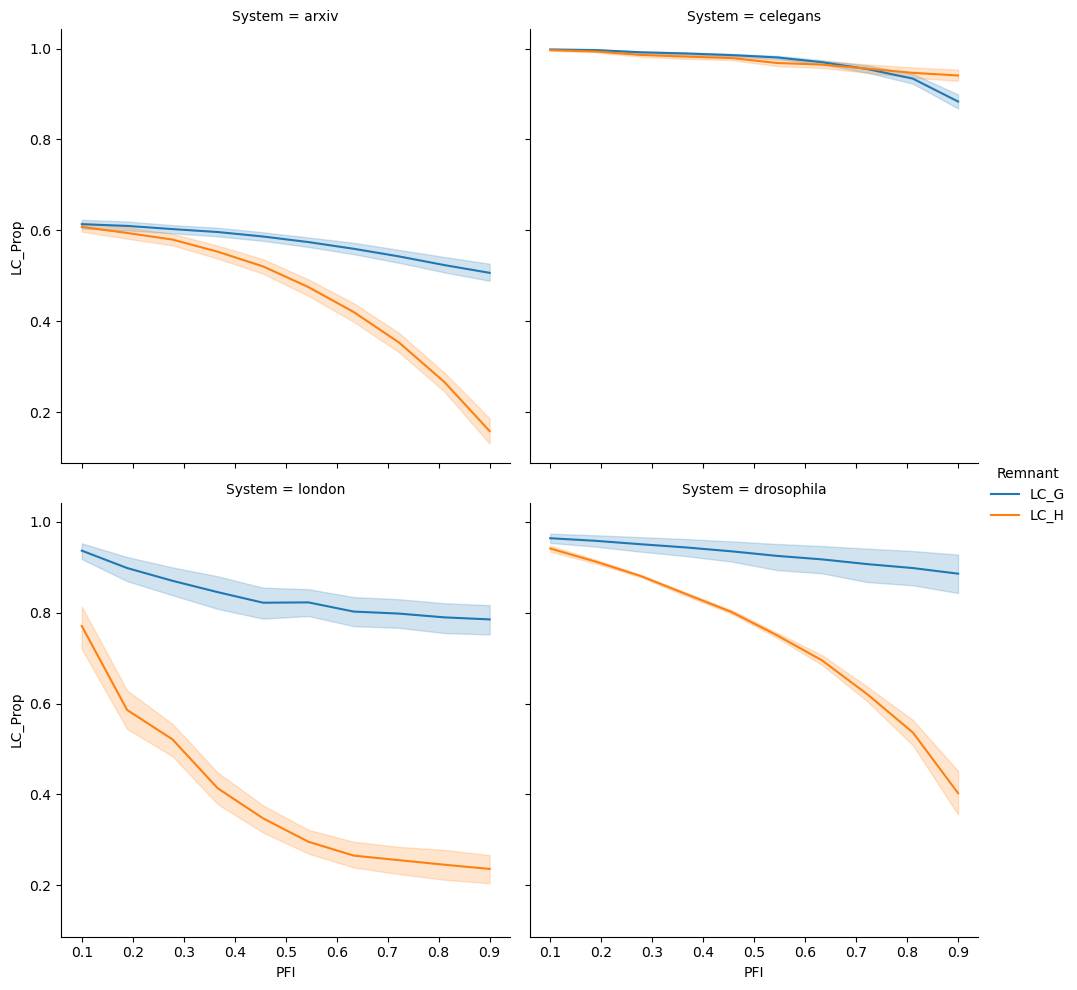

In [17]:
plt.figure()
sns.relplot(
    data=df, kind="line",
    x="PFI", y="LC_Prop",
    hue="Remnant",
    col="System", col_wrap=2,
)

plt.savefig("../../results/plots/line_LC-pfi_ex13.png", transparent=False, facecolor="white")

<Figure size 640x480 with 0 Axes>

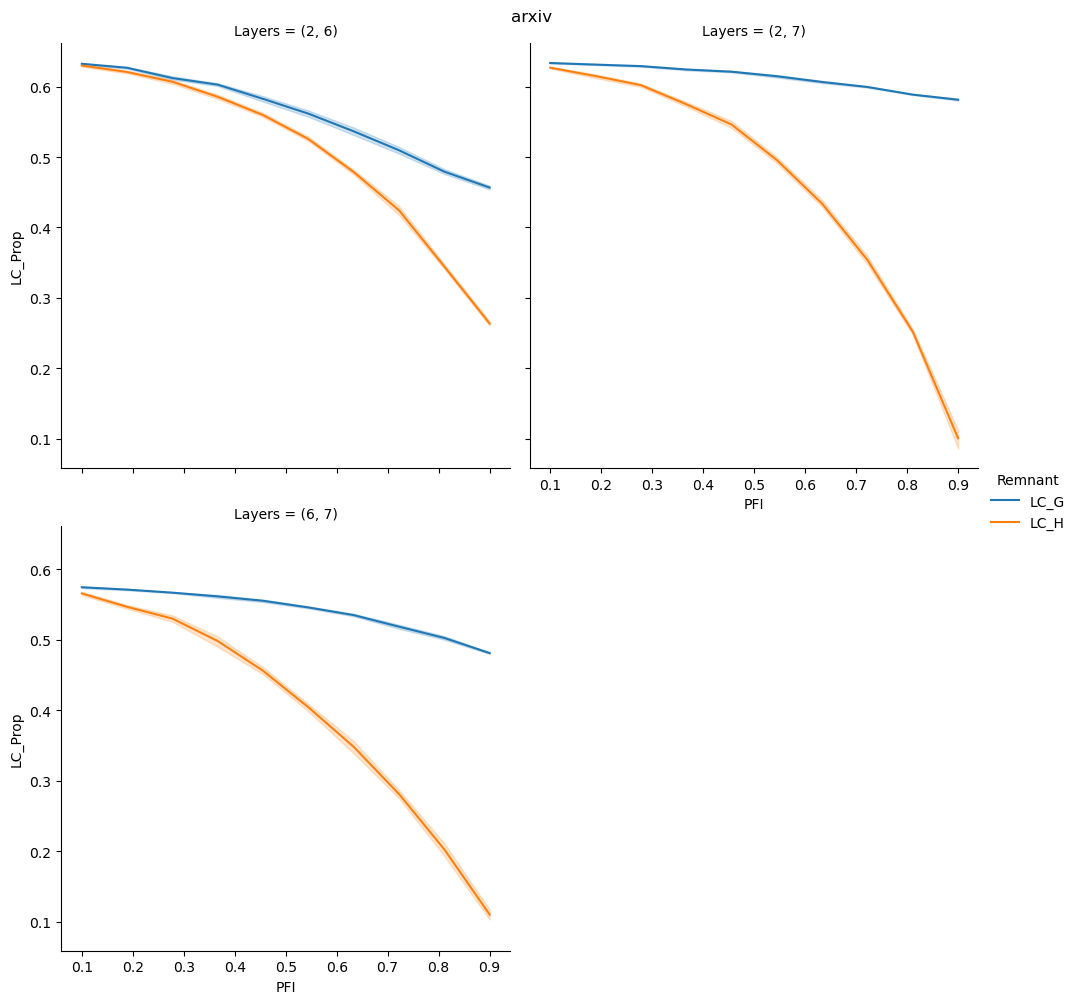

<Figure size 640x480 with 0 Axes>

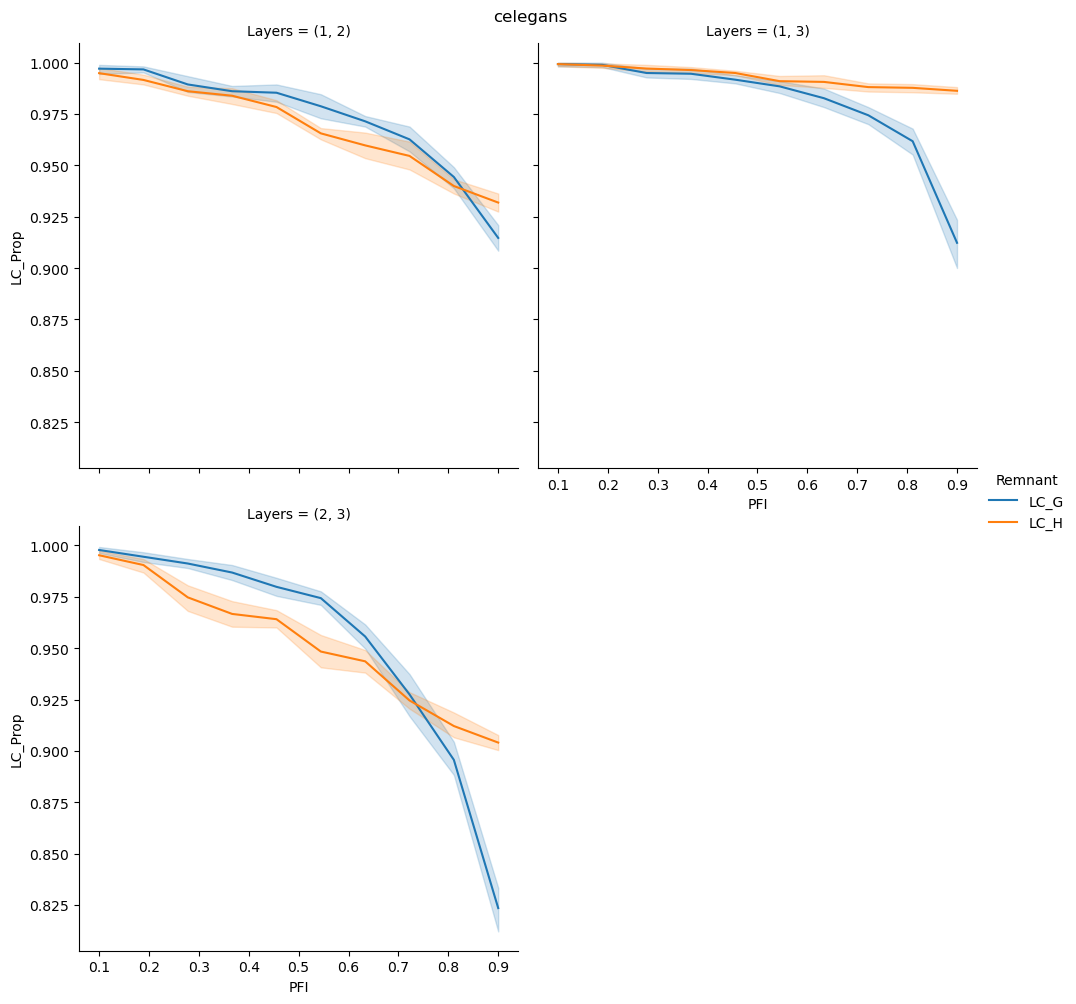

<Figure size 640x480 with 0 Axes>

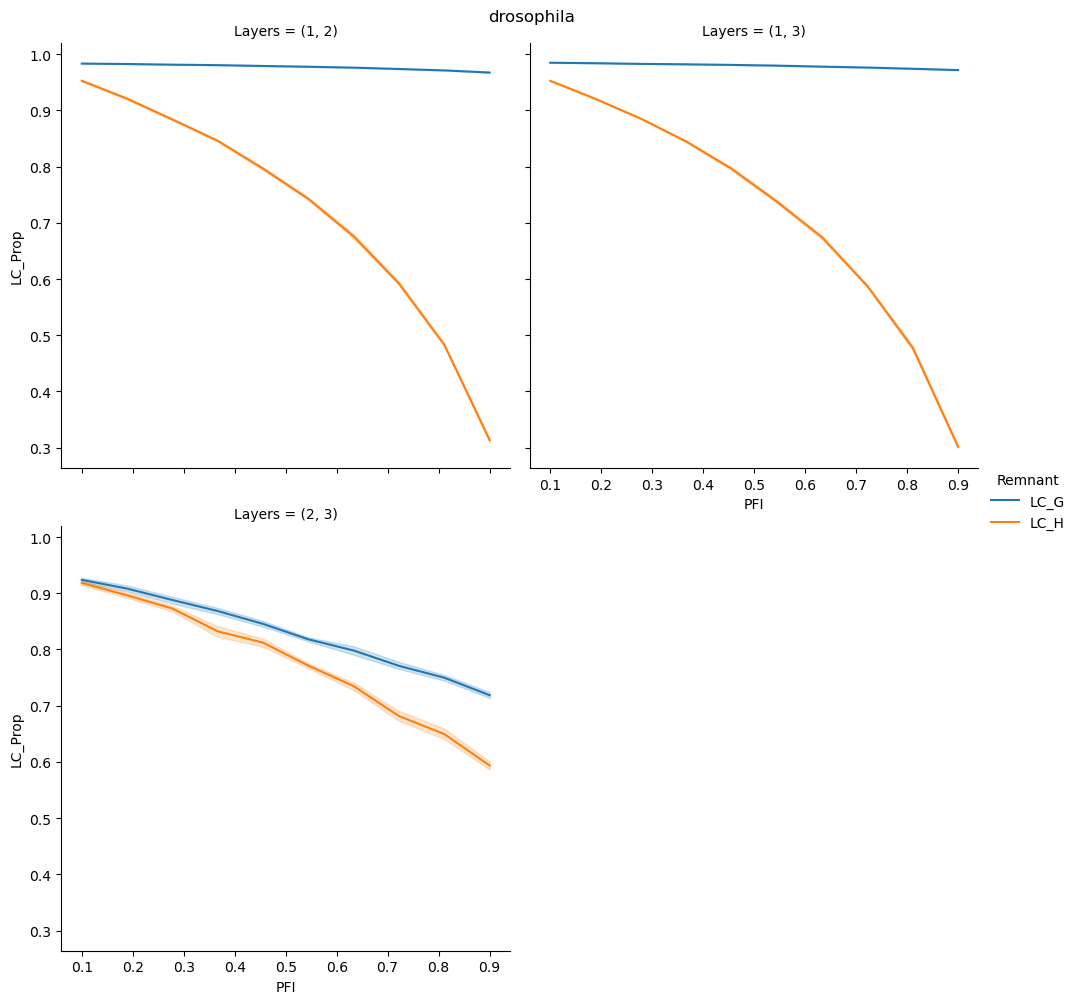

<Figure size 640x480 with 0 Axes>

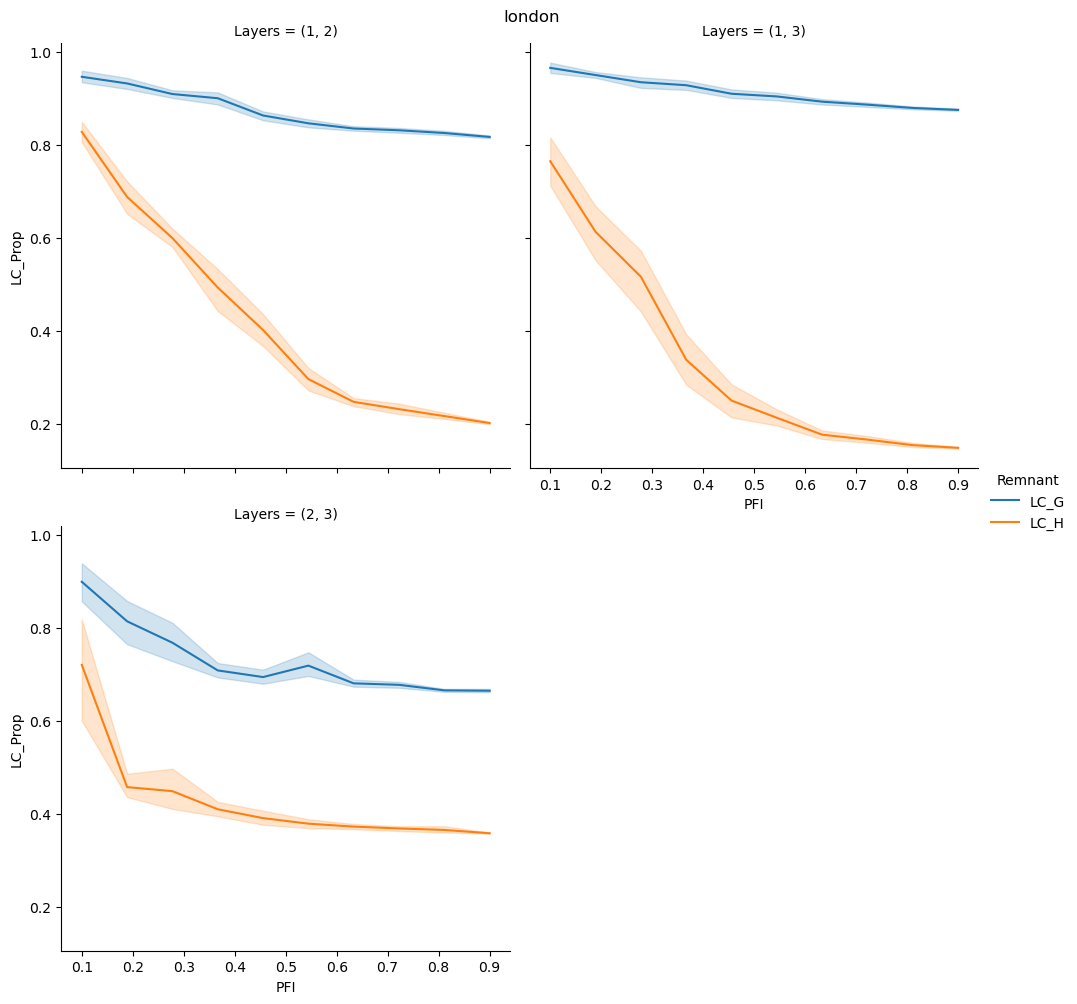

In [18]:
for system in ["arxiv", "celegans", "drosophila", "london"]:
    plt.figure()
    sns.relplot(
        data=df.loc[df["System"] == system], kind="line",
        x="PFI", y="LC_Prop",
        hue="Remnant",
        col="Layers", col_wrap=2,
    )

    plt.suptitle(system, y=1)

    plt.margins(2)
    # plt.tight_layout()

    plt.savefig(f"../../results/plots/line_system={system}_LC-pfi_ex13.png", transparent=False, facecolor="white")

    plt.show()

### Transformations

In [19]:
df_["Delta_LC"] = df_["LC_G"] - df_["LC_H"]

<Figure size 640x480 with 0 Axes>

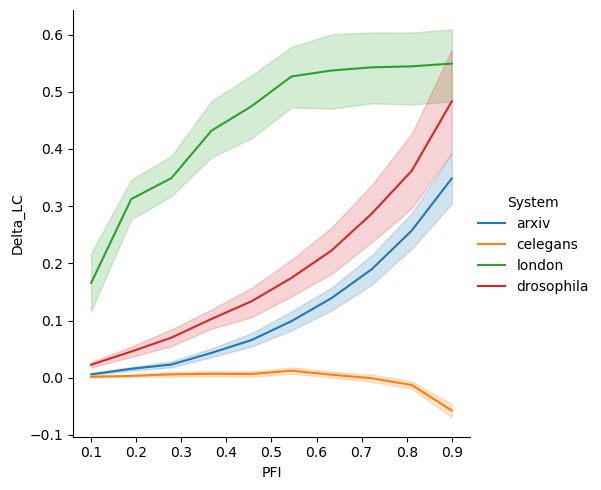

In [20]:
plt.figure()
sns.relplot(
    data=df_, kind="line",
    x="PFI", y="Delta_LC",
    hue="System",
)

<Figure size 640x480 with 0 Axes>

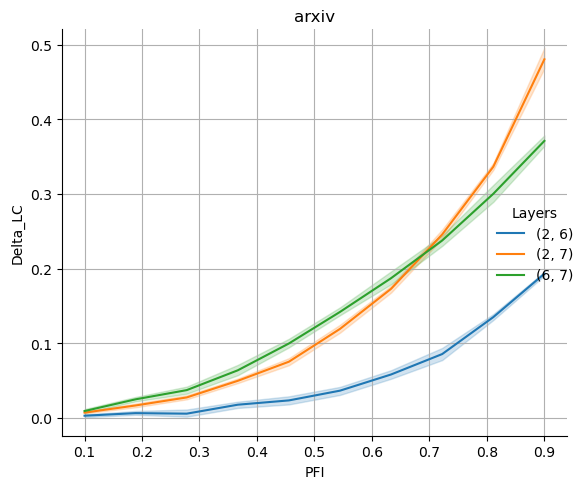

<Figure size 640x480 with 0 Axes>

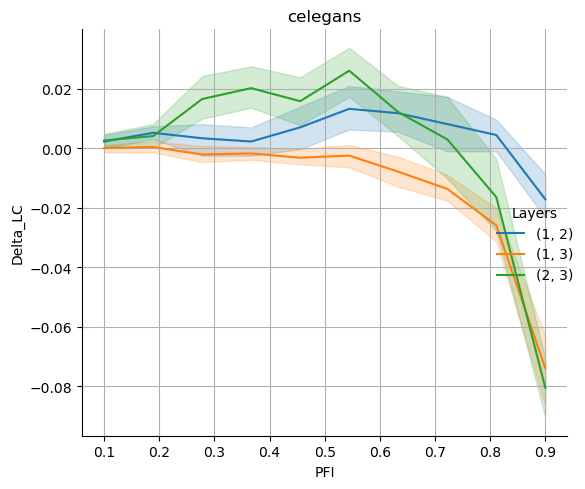

<Figure size 640x480 with 0 Axes>

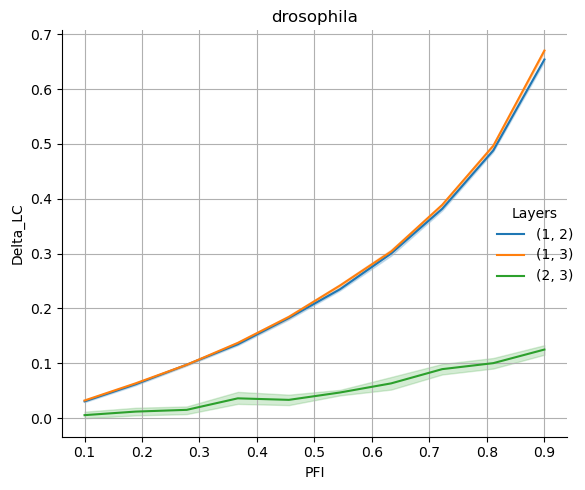

<Figure size 640x480 with 0 Axes>

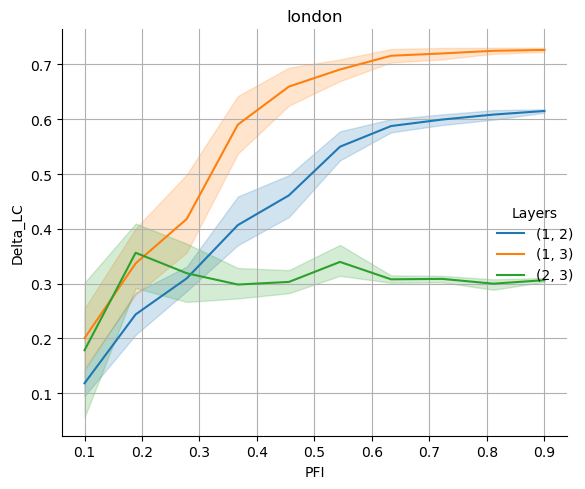

In [21]:
for system in ["arxiv", "celegans", "drosophila", "london"]:
    plt.figure()
    sns.relplot(
        data=df_.loc[df_["System"] == system], kind="line",
        x="PFI", y="Delta_LC",
        hue="Layers"
    )

    plt.title(system)
    plt.grid()

    plt.tight_layout()

    # plt.savefig(f"../../results/plots/line_system={system}_LC-pfi_ex13.png", transparent=False, facecolor="white")

    plt.show()

In [45]:
tmp = []
for tmp_ in list(df_.groupby(["System", "Layers"])):
    tmp_ = tmp_[1]
    tmp_["grad_LC_G"] = np.gradient(tmp_["LC_G"])
    tmp_["grad_LC_H"] = np.gradient(tmp_["LC_H"])
    tmp.append(tmp_)

In [48]:
df_ = pd.concat(tmp)
df_.head()

,System,Layers,PFI,LC_G,LC_H,Delta_LC,grad_LC_G,grad_LC_H
0,arxiv,"(2, 6)",0.100000,0.631557,0.631557,0.000000,-0.003479,-0.011688
1,arxiv,"(2, 6)",0.188889,0.628078,0.619869,0.008209,-0.009531,-0.013914
2,arxiv,"(2, 6)",0.277778,0.612495,0.603729,0.008766,-0.013427,-0.013427
3,arxiv,"(2, 6)",0.366667,0.601224,0.593015,0.008209,-0.012662,-0.019201
4,arxiv,"(2, 6)",0.455556,0.587171,0.565326,0.021845,-0.017949,-0.035133


In [49]:
tmp2 = []
for tmp_ in list(df_.groupby(["System", "Layers"])):
    tmp_ = tmp_[1]
    tmp_["second_grad_LC_G"] = np.gradient(tmp_["grad_LC_G"])
    tmp_["second_grad_LC_H"] = np.gradient(tmp_["grad_LC_H"])
    tmp2.append(tmp_)

In [50]:
df_ = pd.concat(tmp2)
df_.head()

,System,Layers,PFI,LC_G,LC_H,Delta_LC,grad_LC_G,grad_LC_H,second_grad_LC_G,second_grad_LC_H
0,arxiv,"(2, 6)",0.100000,0.631557,0.631557,0.000000,-0.003479,-0.011688,-0.006053,-0.002226
1,arxiv,"(2, 6)",0.188889,0.628078,0.619869,0.008209,-0.009531,-0.013914,-0.004974,-0.000870
2,arxiv,"(2, 6)",0.277778,0.612495,0.603729,0.008766,-0.013427,-0.013427,-0.001565,-0.002644
3,arxiv,"(2, 6)",0.366667,0.601224,0.593015,0.008209,-0.012662,-0.019201,-0.002261,-0.010853
4,arxiv,"(2, 6)",0.455556,0.587171,0.565326,0.021845,-0.017949,-0.035133,-0.004974,-0.011027


In [54]:
df_ = pd.melt(df_, id_vars = ["System", "PFI", "Layers"], value_vars=["grad_LC_G", "grad_LC_H", "second_grad_LC_G", "second_grad_LC_H"], var_name="Gradient", value_name="grad_LC")
df_.head()

Text(0.5, 1, 'arxiv')

<Figure size 640x480 with 0 Axes>

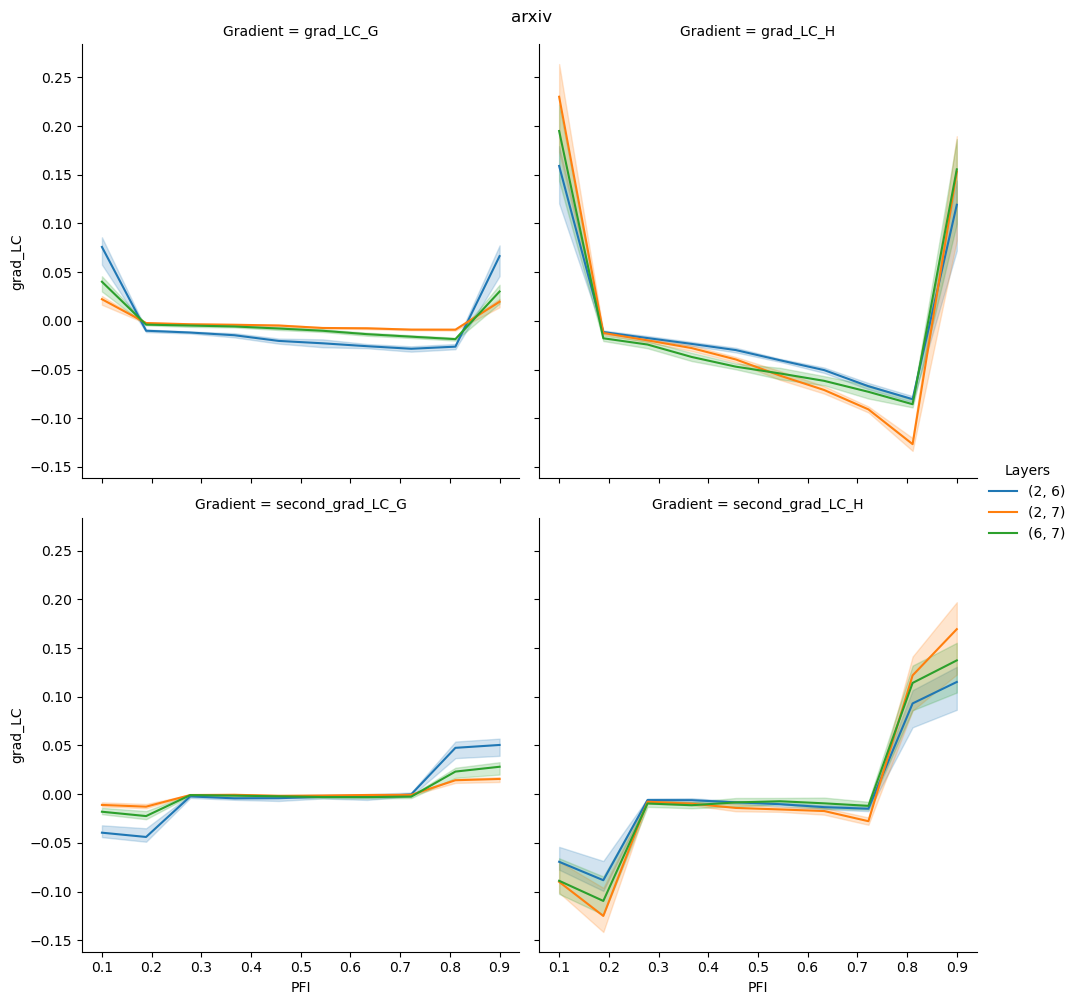

In [66]:
system = "arxiv"
plt.figure()
sns.relplot(
    data=df_.loc[df_["System"] == system], kind="line",
    x="PFI", y="grad_LC",
    hue="Layers",
    col="Gradient", col_wrap=2
)

plt.suptitle(system, y=1)

<Figure size 640x480 with 0 Axes>

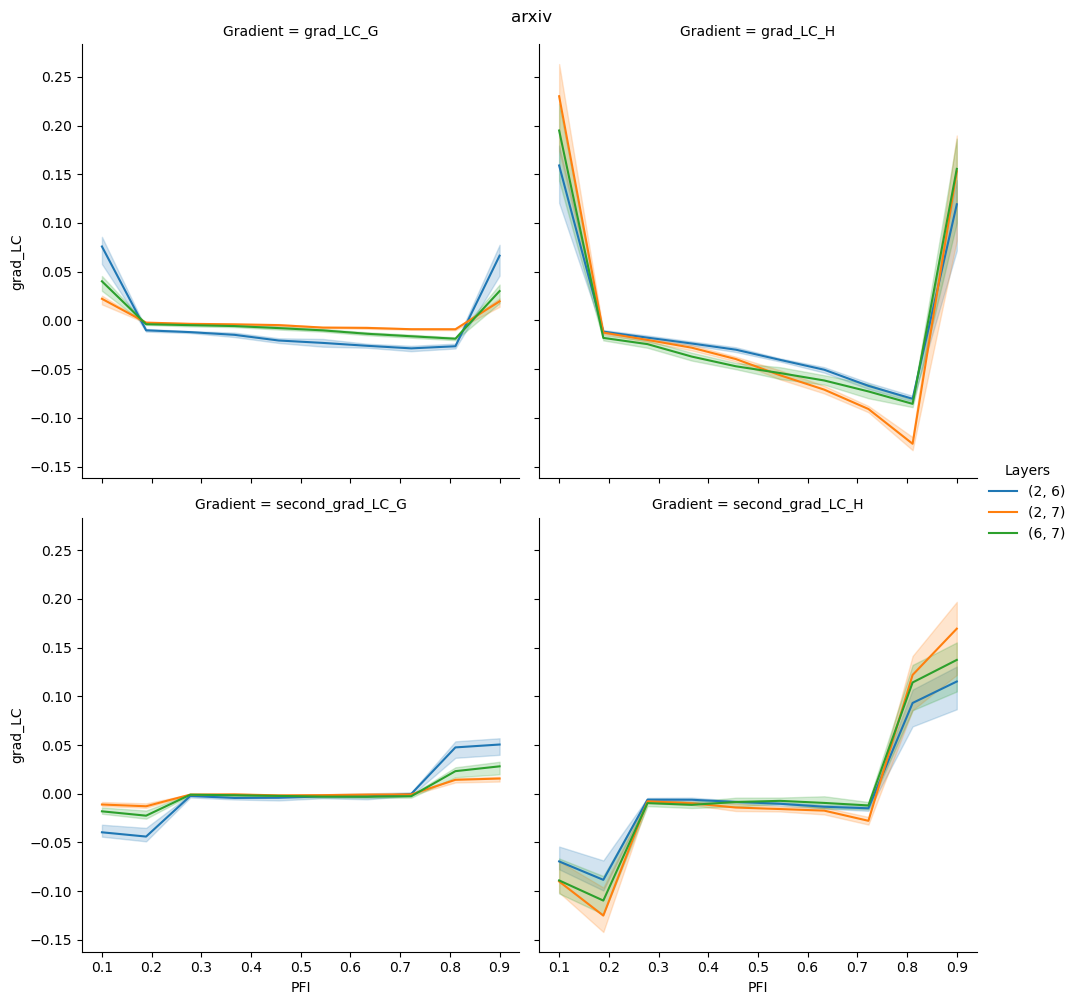

<Figure size 640x480 with 0 Axes>

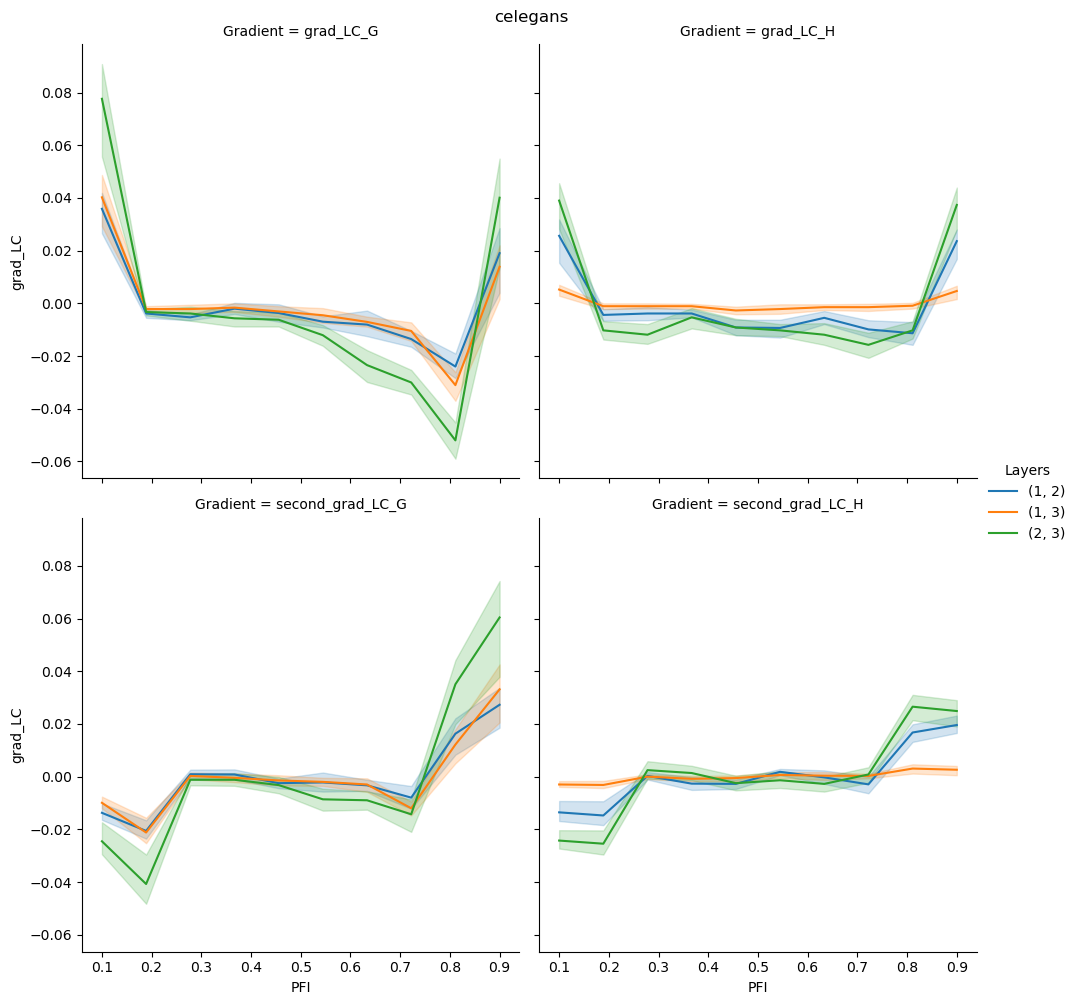

<Figure size 640x480 with 0 Axes>

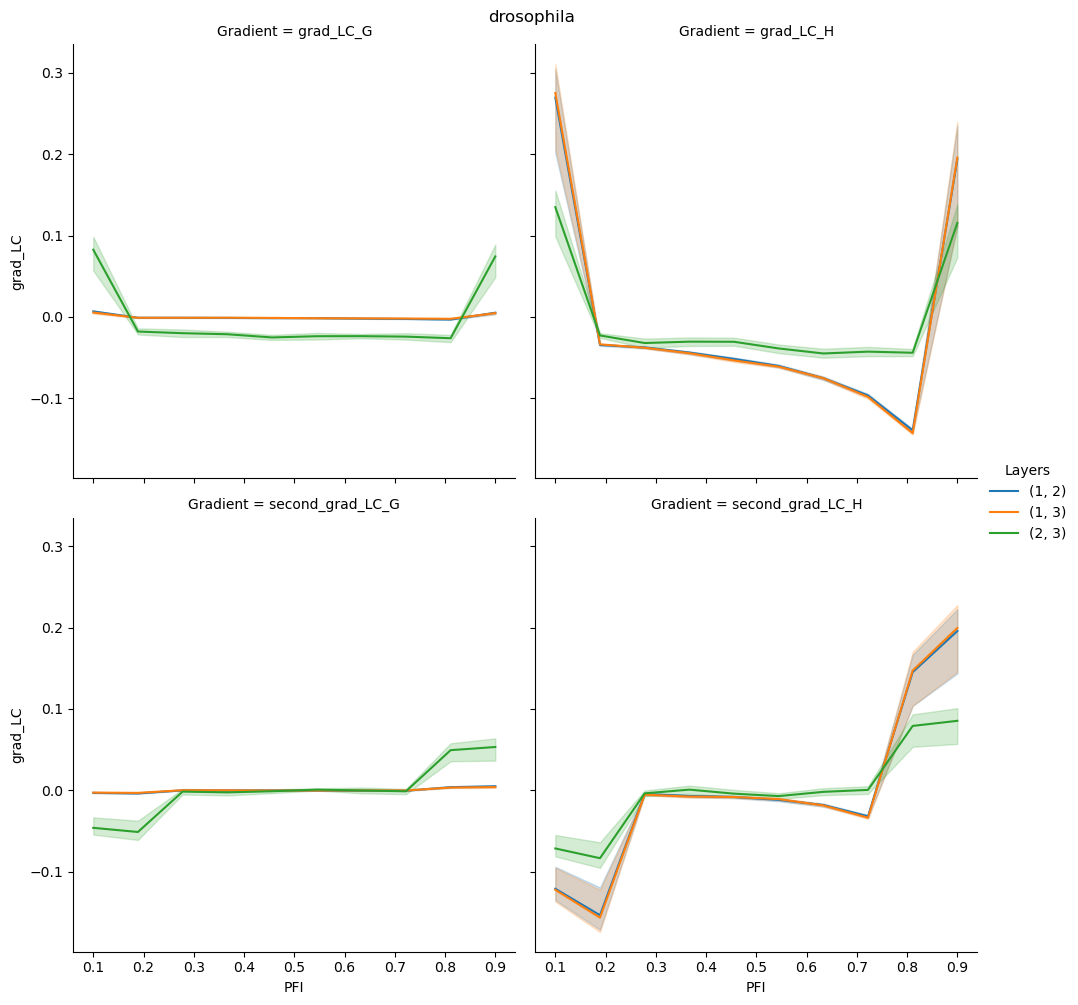

<Figure size 640x480 with 0 Axes>

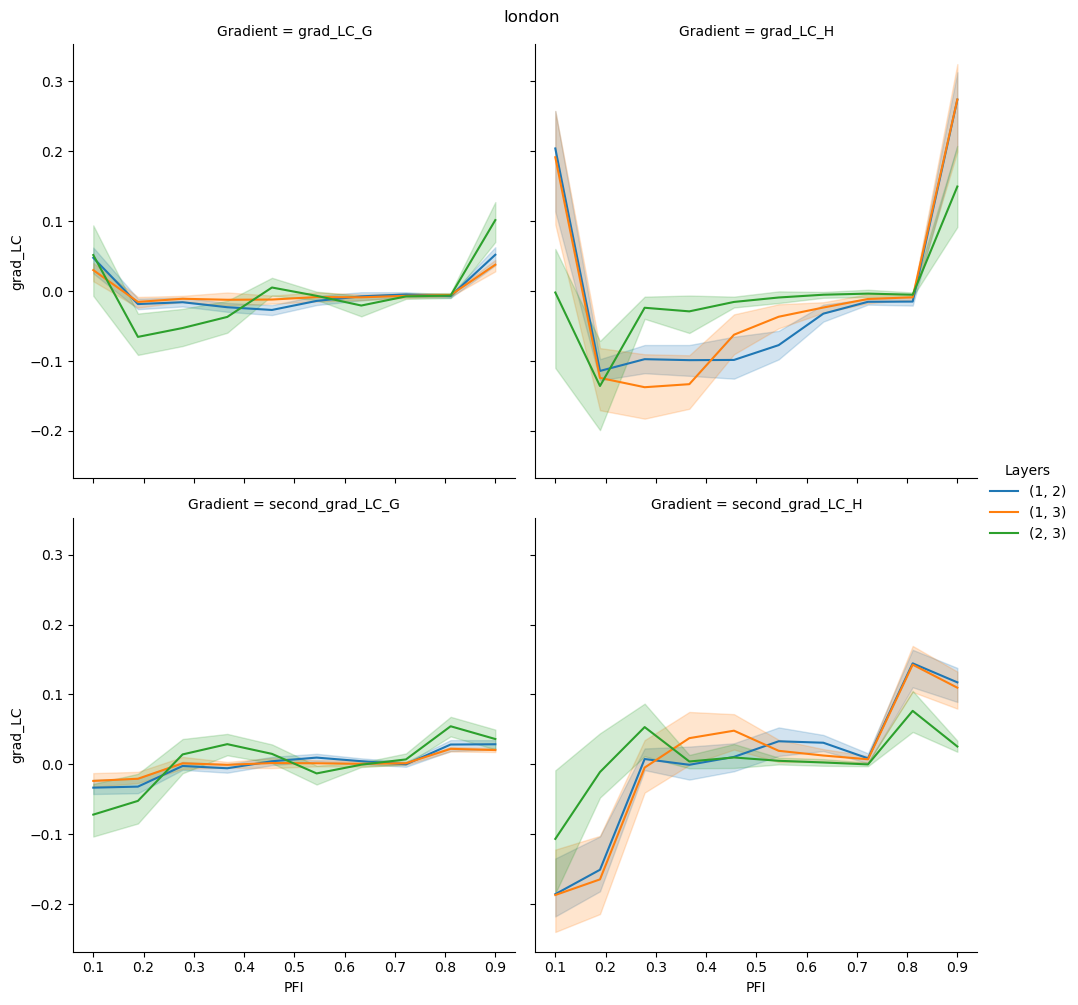

In [67]:
for system in ["arxiv", "celegans", "drosophila", "london"]:
    plt.figure()
    sns.relplot(
        data=df_.loc[df_["System"] == system], kind="line",
        x="PFI", y="grad_LC",
        hue="Layers",
        col="Gradient", col_wrap=2
    )

    plt.suptitle(system, y=1)

    plt.show()